## Task 3: MNIST Classification and Analysis

Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test
contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images
but keep the same test set. Your MLP has 30 neurons in the first layer, 20 in the second layer and then 10
finally for the output layer (corresponding to 10 classes)

1. Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.

2. Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.

3. Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for
MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.



### Importing Libraries

In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist, fashion_mnist
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [177]:
# define a function to set all seeds
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(0)

### Loading the MNIST Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# MLP expects 1D feature vectors per  example. Then converts numpy arrays to Pytorch tensors.
# normalised the data and .long() expected by cross entropy
X_train = torch.from_numpy(X_train).float().reshape(-1, 28 * 28) / 255
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float().reshape(-1, 28 * 28) / 255
y_test = torch.from_numpy(y_test).long()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=torch.Size([60000, 784]), y=torch.Size([60000])
Test: X=torch.Size([10000, 784]), y=torch.Size([10000])


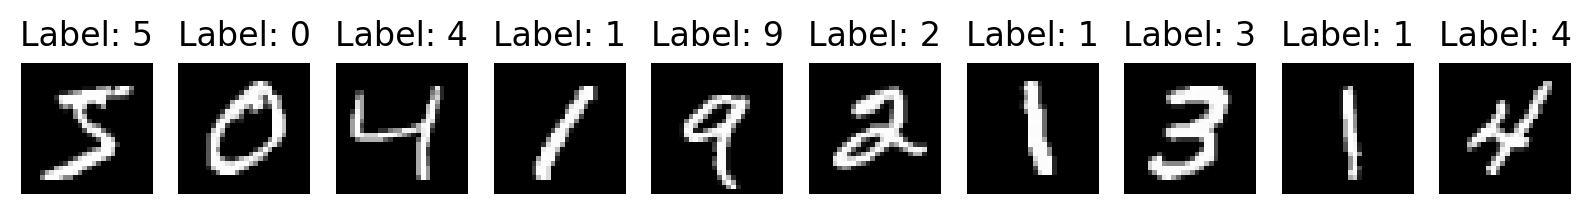

In [179]:
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        img = images[i].reshape(28, 28)  # just reshape here
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train, num_images=10)


## **MLP model**

In [ ]:
batch_size = 128

# Combine features and labels into datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Data loaders yileds mini batches
# shuffle = True for training, not for testing because it reduces overfitting to batch order

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) 

In [ ]:
class MLP(nn.Module):
	def __init__(self, act=nn.ReLU()):
		super().__init__()
		self.l1 = nn.Linear(28 * 28, 30) # input = 784
		self.l2 = nn.Linear(30, 20)
		self.l3 = nn.Linear(20, 10) # 10 logits = o/p = 1o digits
		self.act = act
  
	def forward(self, x):
		x = self.l1(x)
		x = self.act(x)
		x = self.l2(x)
		x = self.act(x)
		x = self.l3(x)
		return x # it's logits (raw score), not probabilities because we will use CrossEntropyLoss
		         # which applies Softmax internally

	def predict(self, x):
		return self.forward(x).argmax(dim=1) # returns highest logit class index as class prediction

# argmax = gives most probable class index,softmax = gives class probabilities.
	
	def get_feats(self, x):
		# storing output after each layer
		feats = []

		x = self.act(self.l1(x))
		feats.append(x.detach().cpu().numpy())

		x = self.act(self.l2(x))
		feats.append(x.detach().cpu().numpy())

		x = self.l3(x)
		feats.append(x.detach().cpu().numpy())

		return feats


In [182]:
def print_metrics(model):
	pred = model.predict(X_test)
	acc = (pred == y_test).float().mean()
	print(f"Accuracy: {acc.item()}")

	cm = confusion_matrix(y_test, pred)

	f1 = f1_score(y_test, pred, average=None)
	accuracies = []
	recalls = []
 
	for i in range(10):
		accuracies.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
		recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))
	df = pd.DataFrame(np.array([f1, accuracies, recalls]).T, index=range(10), columns=["F1 Score", "Accuracy", "Recall"])
	df.index.name = "Class"
	display(df.T)
 
	plt.figure(figsize=(6, 6))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
	plt.title("Confusion Matrix")
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()
 
	return cm


In [183]:
model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Training loop ----
epochs = 5
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.4017
Epoch [2/5], Loss: 0.2091
Epoch [3/5], Loss: 0.2807
Epoch [4/5], Loss: 0.1752
Epoch [5/5], Loss: 0.2258


### Train and Predict Functions

MLP Test Accuracy: 0.9507, F1-score: 0.9501
Confusion Matrix:


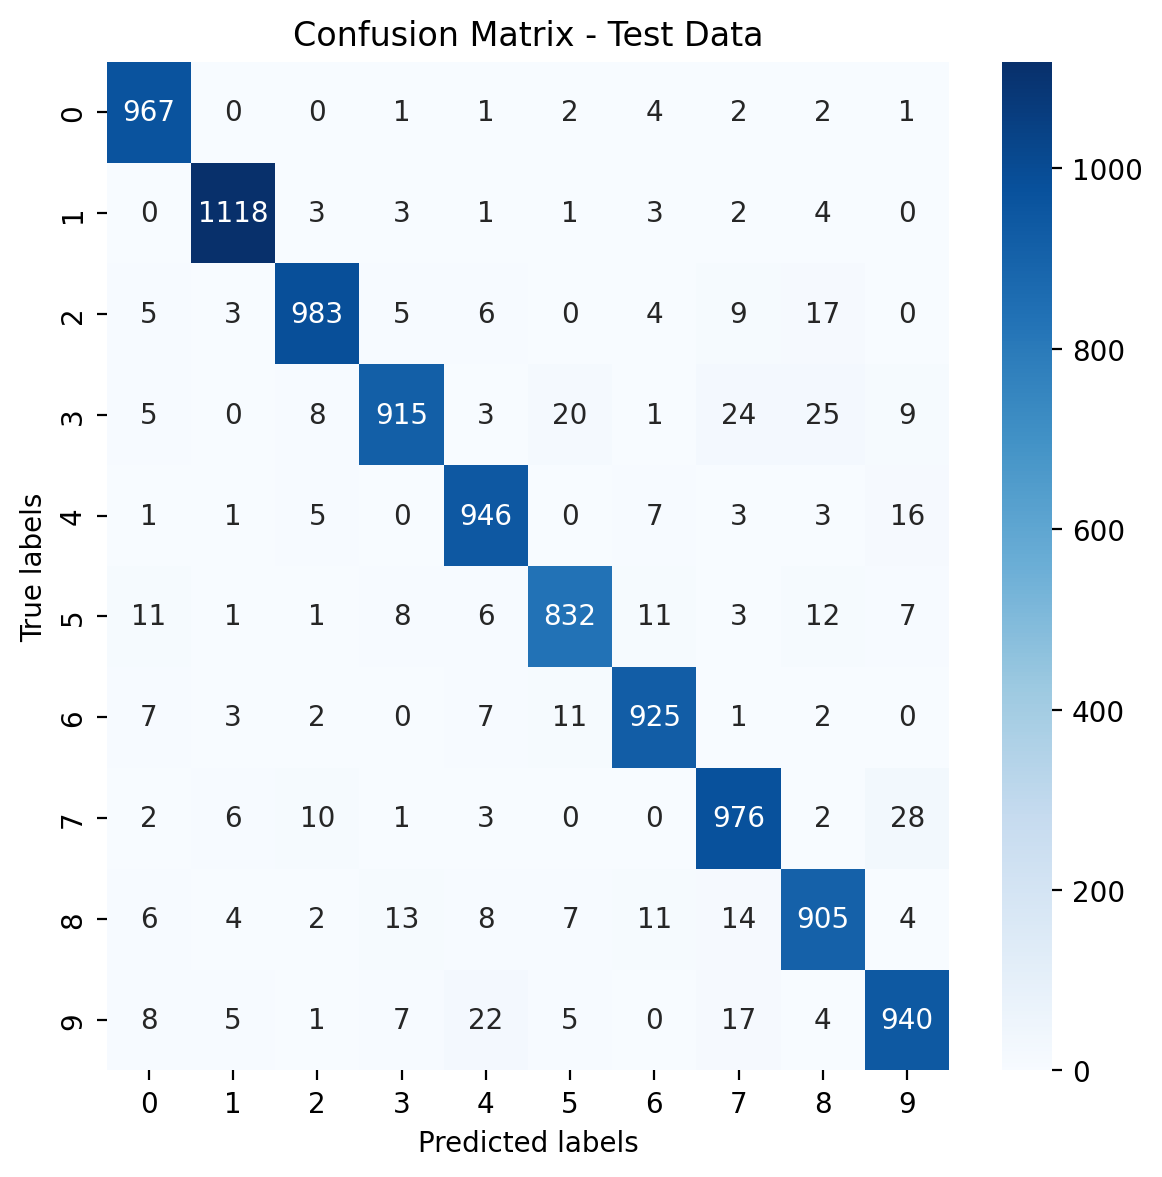

Most commonly confused with 0: [6 5]
Most commonly confused with 1: [8 3]
Most commonly confused with 2: [8 7]
Most commonly confused with 3: [8 7]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [8 0]
Most commonly confused with 6: [5 4]
Most commonly confused with 7: [9 2]
Most commonly confused with 8: [7 3]
Most commonly confused with 9: [4 7]


In [184]:
 
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())


acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"MLP Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)


# Plot confusion matrices
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs)
axs.set_title('Confusion Matrix - Test Data')
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels')


plt.tight_layout()
plt.show()

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])



In [185]:

print('Test Data Classification Report:')
print(classification_report(y_test, y_pred))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.96      0.91      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.93      0.94       892
           6       0.96      0.97      0.96       958
           7       0.93      0.95      0.94      1028
           8       0.93      0.93      0.93       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



## **Random Forest and Logistic Regression**

In [ ]:
# Convert training data to numpy arrays, because skikit models like RF, LR expect numpy arrays
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()

In [187]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

In [188]:
# ---- Random Forest ----
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_np, y_train_np)
y_rf_pred = rf_model.predict(X_test_np)

print(f'Random Forest Accuracy: {np.mean(y_rf_pred == y_test_np):.4f}')

# ---- Logistic Regression ----
lr_model = LogisticRegression(max_iter=1000, random_state=0)
lr_model.fit(X_train_scaled, y_train_np)
y_lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression Accuracy: {np.mean(y_lr_pred == y_test_np):.4f}')

Random Forest Accuracy: 0.9705
Logistic Regression Accuracy: 0.9216


### Performance Metrics

In [189]:
# F1 score and confusion matrix for Random Forest
f1_rf = f1_score(y_test, y_rf_pred, average='macro')

# F1 score and confusion matrix for Logistic Regression
f1_lr = f1_score(y_test, y_lr_pred, average='macro')

# Print F1 scores
print(f'Random Forest F1 Score: {f1_rf:.4f}')
print(f'Logistic Regression F1 Score: {f1_lr:.4f}')


Random Forest F1 Score: 0.9702
Logistic Regression F1 Score: 0.9206


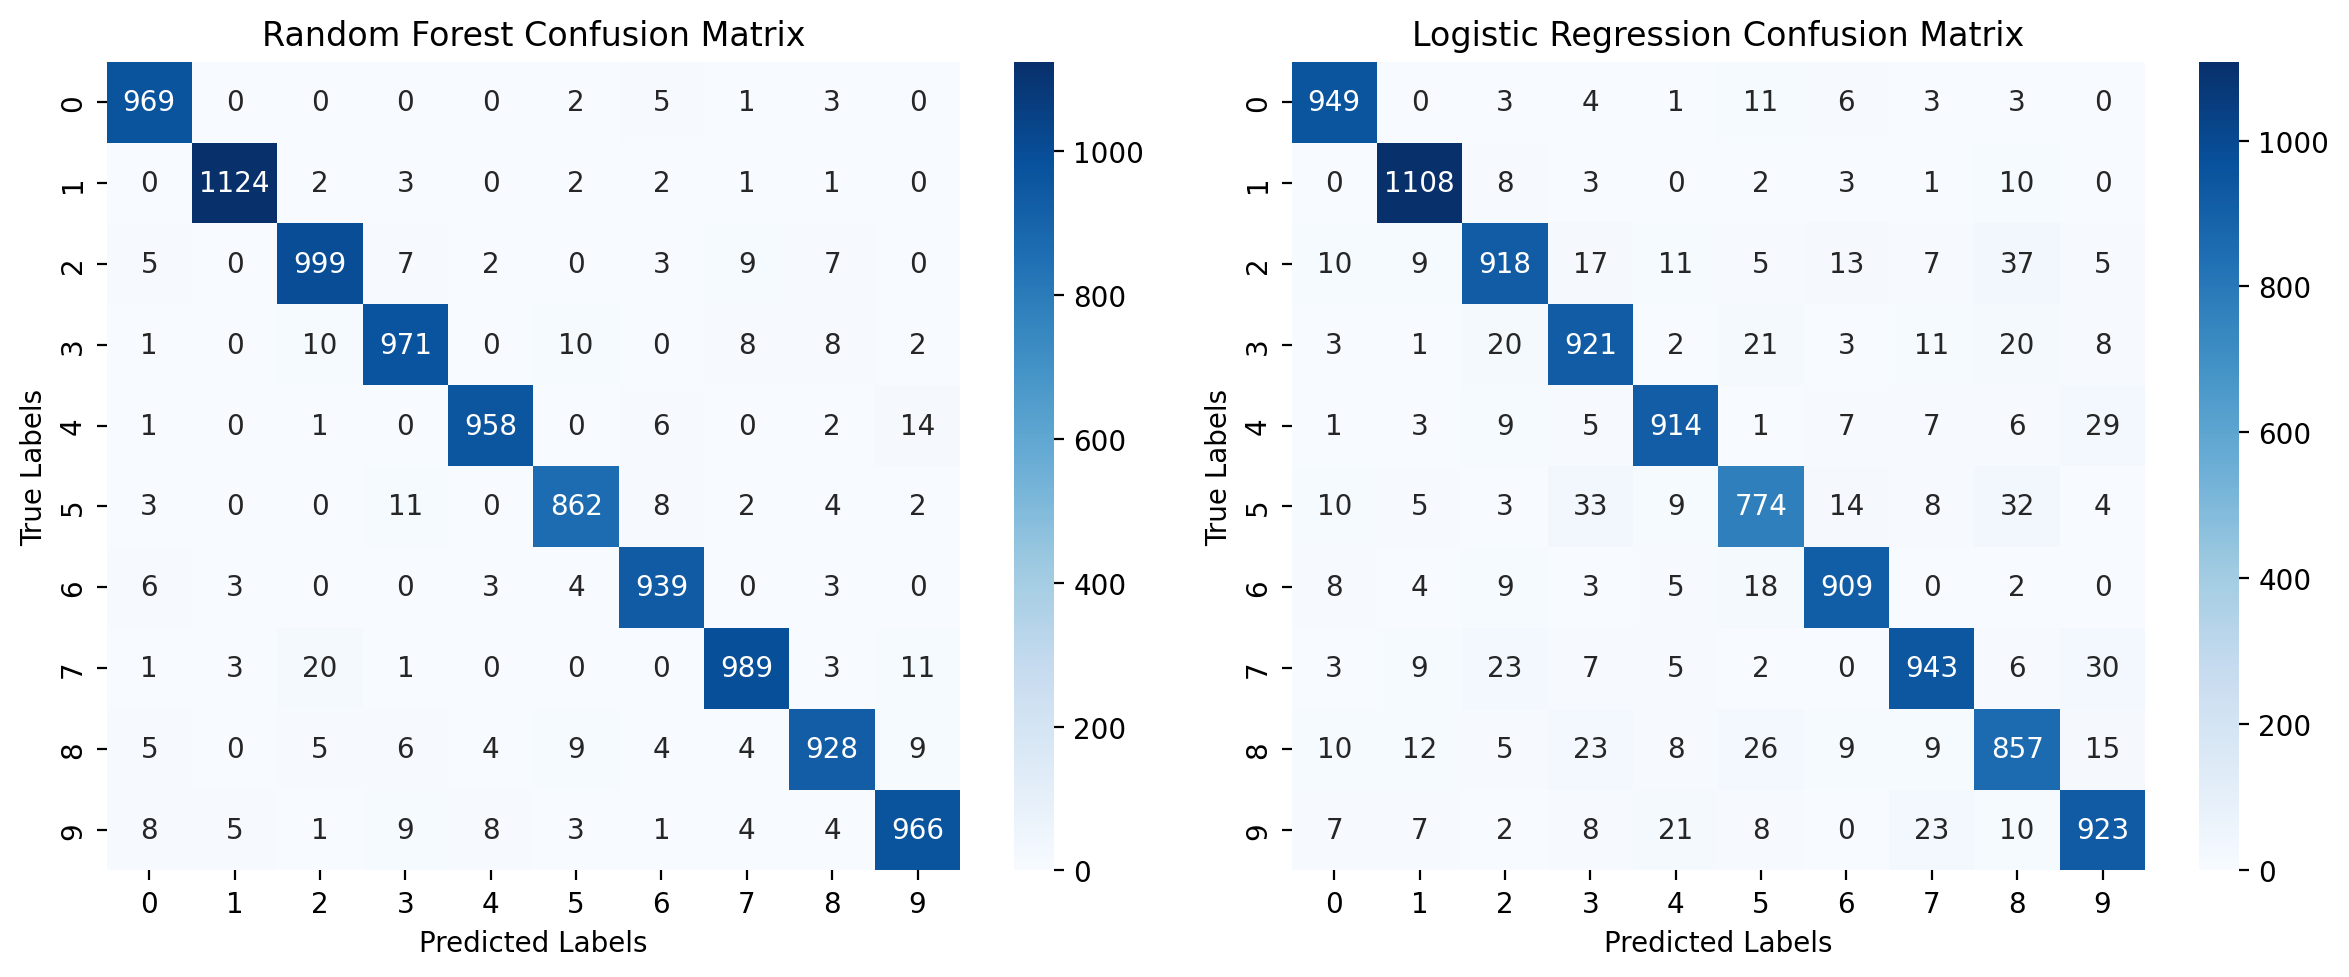

Misclassification for Random Forest:
Most commonly confused with 0: [6 8]
Most commonly confused with 1: [3 2]
Most commonly confused with 2: [7 3]
Most commonly confused with 3: [5 2]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 6]
Most commonly confused with 6: [0 5]
Most commonly confused with 7: [2 9]
Most commonly confused with 8: [9 5]
Most commonly confused with 9: [3 0]


----------------------------------------------------------------------------------------------------


Misclassification for Logistic Regression:
Most commonly confused with 0: [5 6]
Most commonly confused with 1: [8 2]
Most commonly confused with 2: [8 3]
Most commonly confused with 3: [5 2]
Most commonly confused with 4: [9 2]
Most commonly confused with 5: [3 8]
Most commonly confused with 6: [5 2]
Most commonly confused with 7: [9 2]
Most commonly confused with 8: [5 3]
Most commonly confused with 9: [7 4]


In [203]:
# ---- Confusion Matrices ----
cm_rf = confusion_matrix(y_test_np, y_rf_pred)
cm_lr = confusion_matrix(y_test_np, y_lr_pred)

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Random Forest Confusion Matrix')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Logistic Regression Confusion Matrix')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


print("Misclassification for Random Forest:")
for i in range(10):
	print(f"Most commonly confused with {i}:", cm_rf[i].argsort()[-3:-1][::-1])

print("\n")
print("-"*100)	
print("\n")
print("Misclassification for Logistic Regression:")
for i in range(10):
	print(f"Most commonly confused with {i}:", cm_lr[i].argsort()[-3:-1][::-1])

In [191]:
print('Random Forest Classification Report')
print(classification_report(y_test_np, y_rf_pred))
print("-"*50)
print('\nLogistic Regression Classification Report')
print(classification_report(y_test_np, y_lr_pred))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

--------------------------------------------------

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
  

## Comparison between MLP, Random Forest and Logistic Regression

**Performance Metrics**

The table below shows the accuracy and F1 score on the test set provided in the MNIST dataset for all the three models:

| Model      | Accuracy | F1 Score |
|------------|----------|----------|
| MLP        | 95.07%     | 0.9501    |
| Random Forest   | 97.05%     | 0.9702    |
| Logistic Regression    | 92.16%     | 0.9206     |

**Confusions Matrices**

The confusion matrices for all the models on the test set are shown below:

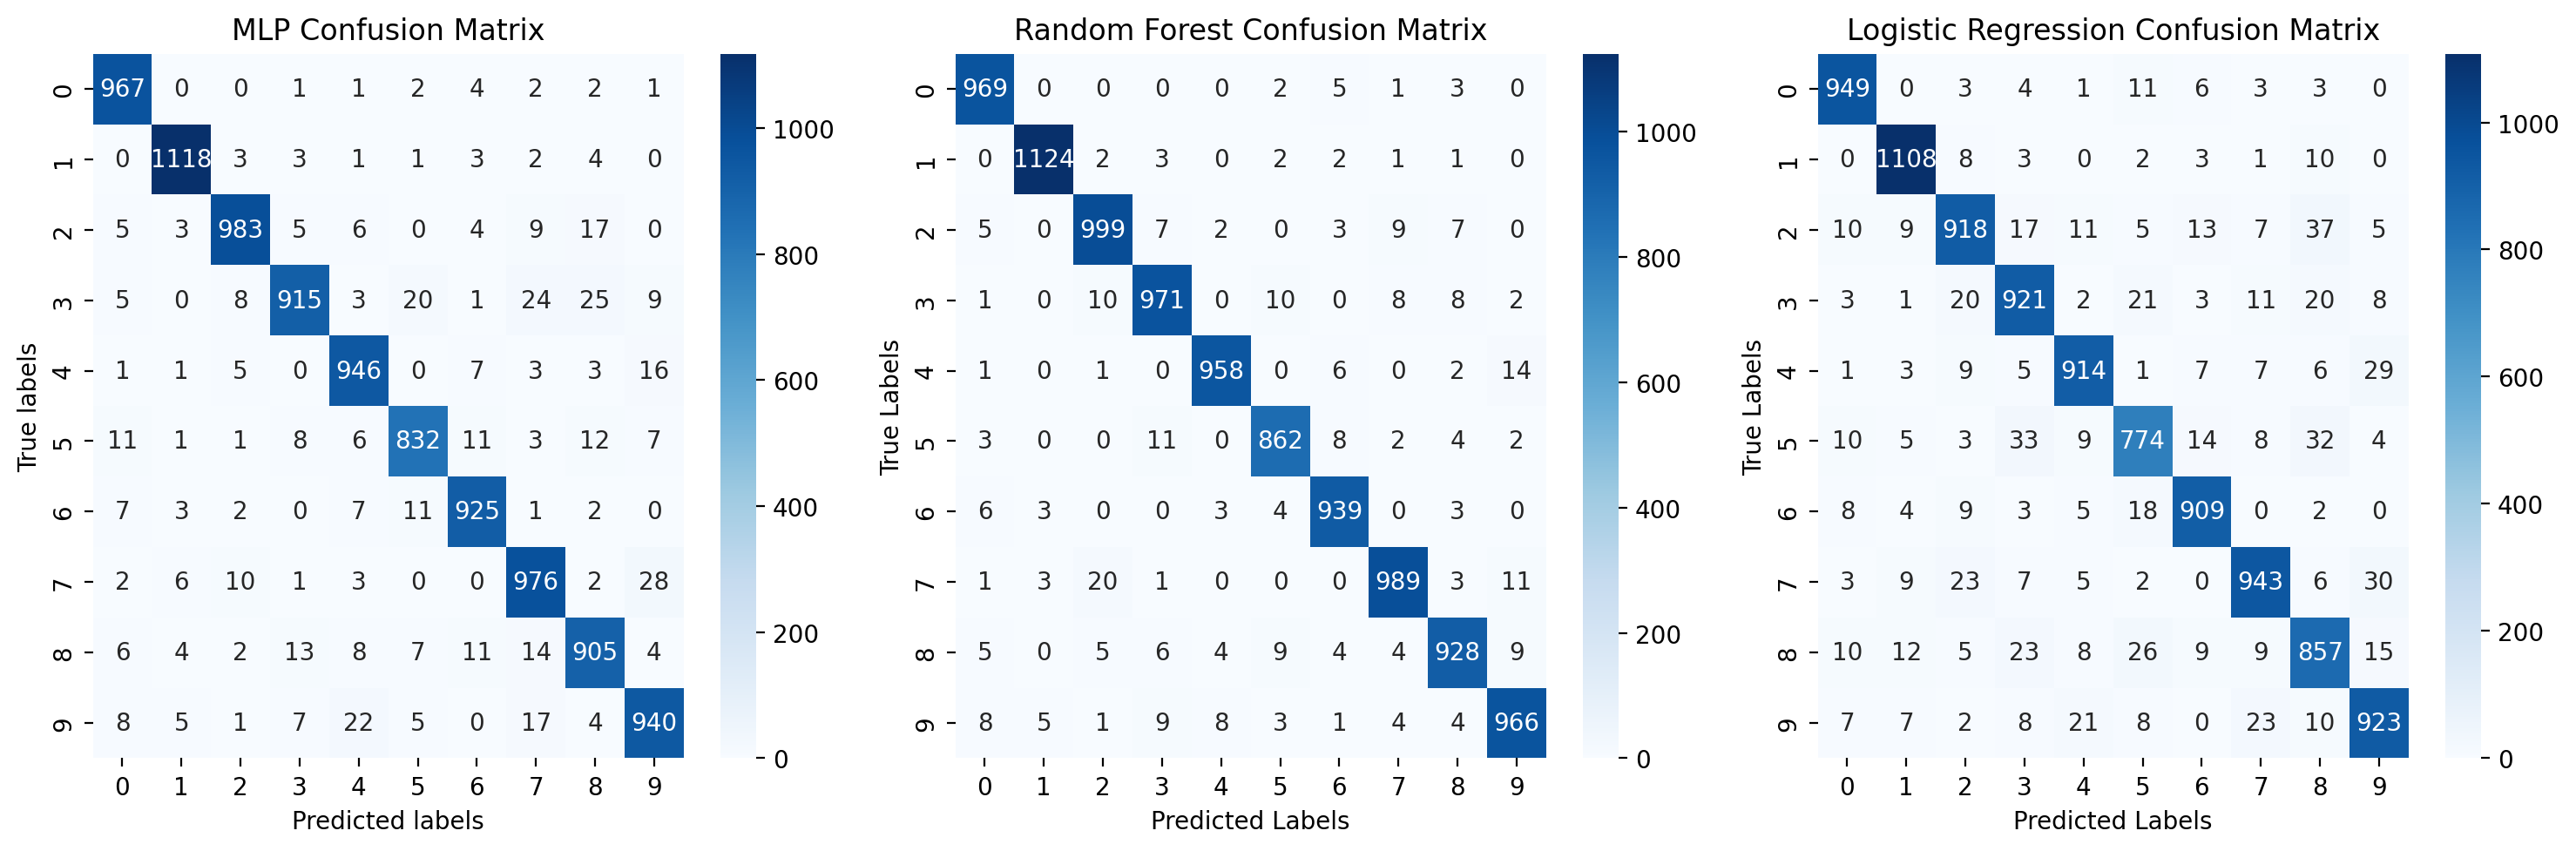

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Confusion Matrix for MLP
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('MLP Confusion Matrix')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')

# Confusion Matrix for Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Confusion Matrix for Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Logistic Regression Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


## **Observations and Discussion**

### **1. Performance Comparison**

| Model | Accuracy | F1-Score |
|:------|:----------|:---------|
| **MLP (Neural Network)** | **95.07%** | **0.9501** |
| **Random Forest** | **97.05%** | **0.9702** |
| **Logistic Regression** | **92.16%** | **0.9206** |

- **Random Forest** achieved the highest accuracy and F1-score, indicating strong performance across all digits.  
- **MLP** performed slightly lower but still achieved competitive accuracy, showing that the neural network successfully learned complex non-linear relationships.  
- **Logistic Regression** had the lowest accuracy and F1-score, suggesting it struggles to capture non-linear patterns in handwritten digits.

---

### **2. Confusion Matrix Analysis**

- **Random Forest:**  
  - Shows the cleanest diagonal line, meaning most predictions are correct.  
  - Very few off-diagonal elements, indicating minimal misclassifications.  
  - Occasionally confuses digits like **5 and 3**, or **4 and 9**, which share similar shapes.

- **MLP:**  
  - Performs well overall but makes more mistakes than Random Forest.  
  - Some confusion is visible between **4 and 9**, **3 and 7** and **5 and 6**, which can visually appear similar in handwritten form.  
  - Neural models can be slightly sensitive to small pixel variations.

- **Logistic Regression:**  
  - The confusion matrix shows more off-diagonal spread.  
  - Misclassifies **8 as 3 or 9**, **2 and 7** and **5 as 6** quite often, as it is a linear model that cannot handle complex curved decision boundaries.  
  - Still maintains reasonable accuracy given its simplicity.

---

### **3. Discussion on Misclassifications**

- **Similar Digit Shapes:** Most misclassifications happen between digits with overlapping visual features (e.g., 4↔9, 3↔5, 5↔6, 8↔9).  
- **MLP vs Logistic Regression:** The MLP’s non-linear activations (ReLU) help it better separate overlapping classes compared to Logistic Regression.  
- **Random Forest:** Captures both non-linear boundaries and feature interactions effectively, explaining its superior accuracy.  
- **General Trend:** Models with non-linear learning capacity (MLP, Random Forest) perform significantly better than linear models on image data.

---

### **Conclusions**

Overall, the **Random Forest model** outperformed both the **MLP** and **Logistic Regression** models in terms of **accuracy**, **F1 score**, and **misclassification rate** in the confusion matrix.

- The **MLP (Multi-Layer Perceptron)**, being a neural network, can learn non-linear relationships within the data. This helps it distinguish between similar-looking digits more effectively than a linear model.  
  However, since the hidden layers in this implementation contained relatively few neurons, the model’s capacity was limited, preventing it from outperforming the Random Forest.

- The **Random Forest**, as an ensemble method, combines multiple decision trees and averages their results. This reduces overfitting and improves generalization, which explains its strong and consistent performance.

- The **Logistic Regression** model, being linear, is unable to capture complex or non-linear patterns in handwritten digits. Consequently, it performed the weakest among the three models, though it still provides a good baseline for comparison.

In summary, Random Forest achieved the best overall performance, MLP showed strong potential with proper tuning, and Logistic Regression served as a simple but less capable baseline model.


### TSNE Visualisation

In [ ]:
def plot_tsne(model, X_data, y_data, device = 'cpu'):
    model.eval()

    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)

    # Flatten if needed
    if X_tensor.ndim == 3:
        X_tensor = X_tensor.view(-1, 28*28) 
#  Ensures i/p images are flattened into 784-D vectors (since the MLP expects this format). 
    
    with torch.no_grad():
        feats = model.get_feats(X_tensor)

    feat_np = feats[1]  # 2nd layer (20 neurons)
    feat_np = np.array(feat_np)

    # Normalize features (important for t-SNE stability), mean = 0, std = 1
    # prevents dominant features from skewing the t-SNE results, because t-SNE is sensitive to feature scales
    feat_np = feats[1]  # 20-neuron layer
    feat_np = (feat_np - feat_np.mean(axis=0)) / (feat_np.std(axis=0) + 1e-6)

    print(f"Running t-SNE on {feat_np.shape[0]} samples...")

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, init='pca')
    embeddings_2d = tsne.fit_transform(feat_np)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_data, cmap="tab10", s=5)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE Visualization — Layer 2 Embeddings")
    plt.tight_layout()
    plt.show()


C:\Users\ginis\AppData\Local\Temp\ipykernel_18660\3192885909.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)


Running t-SNE on 60000 samples...


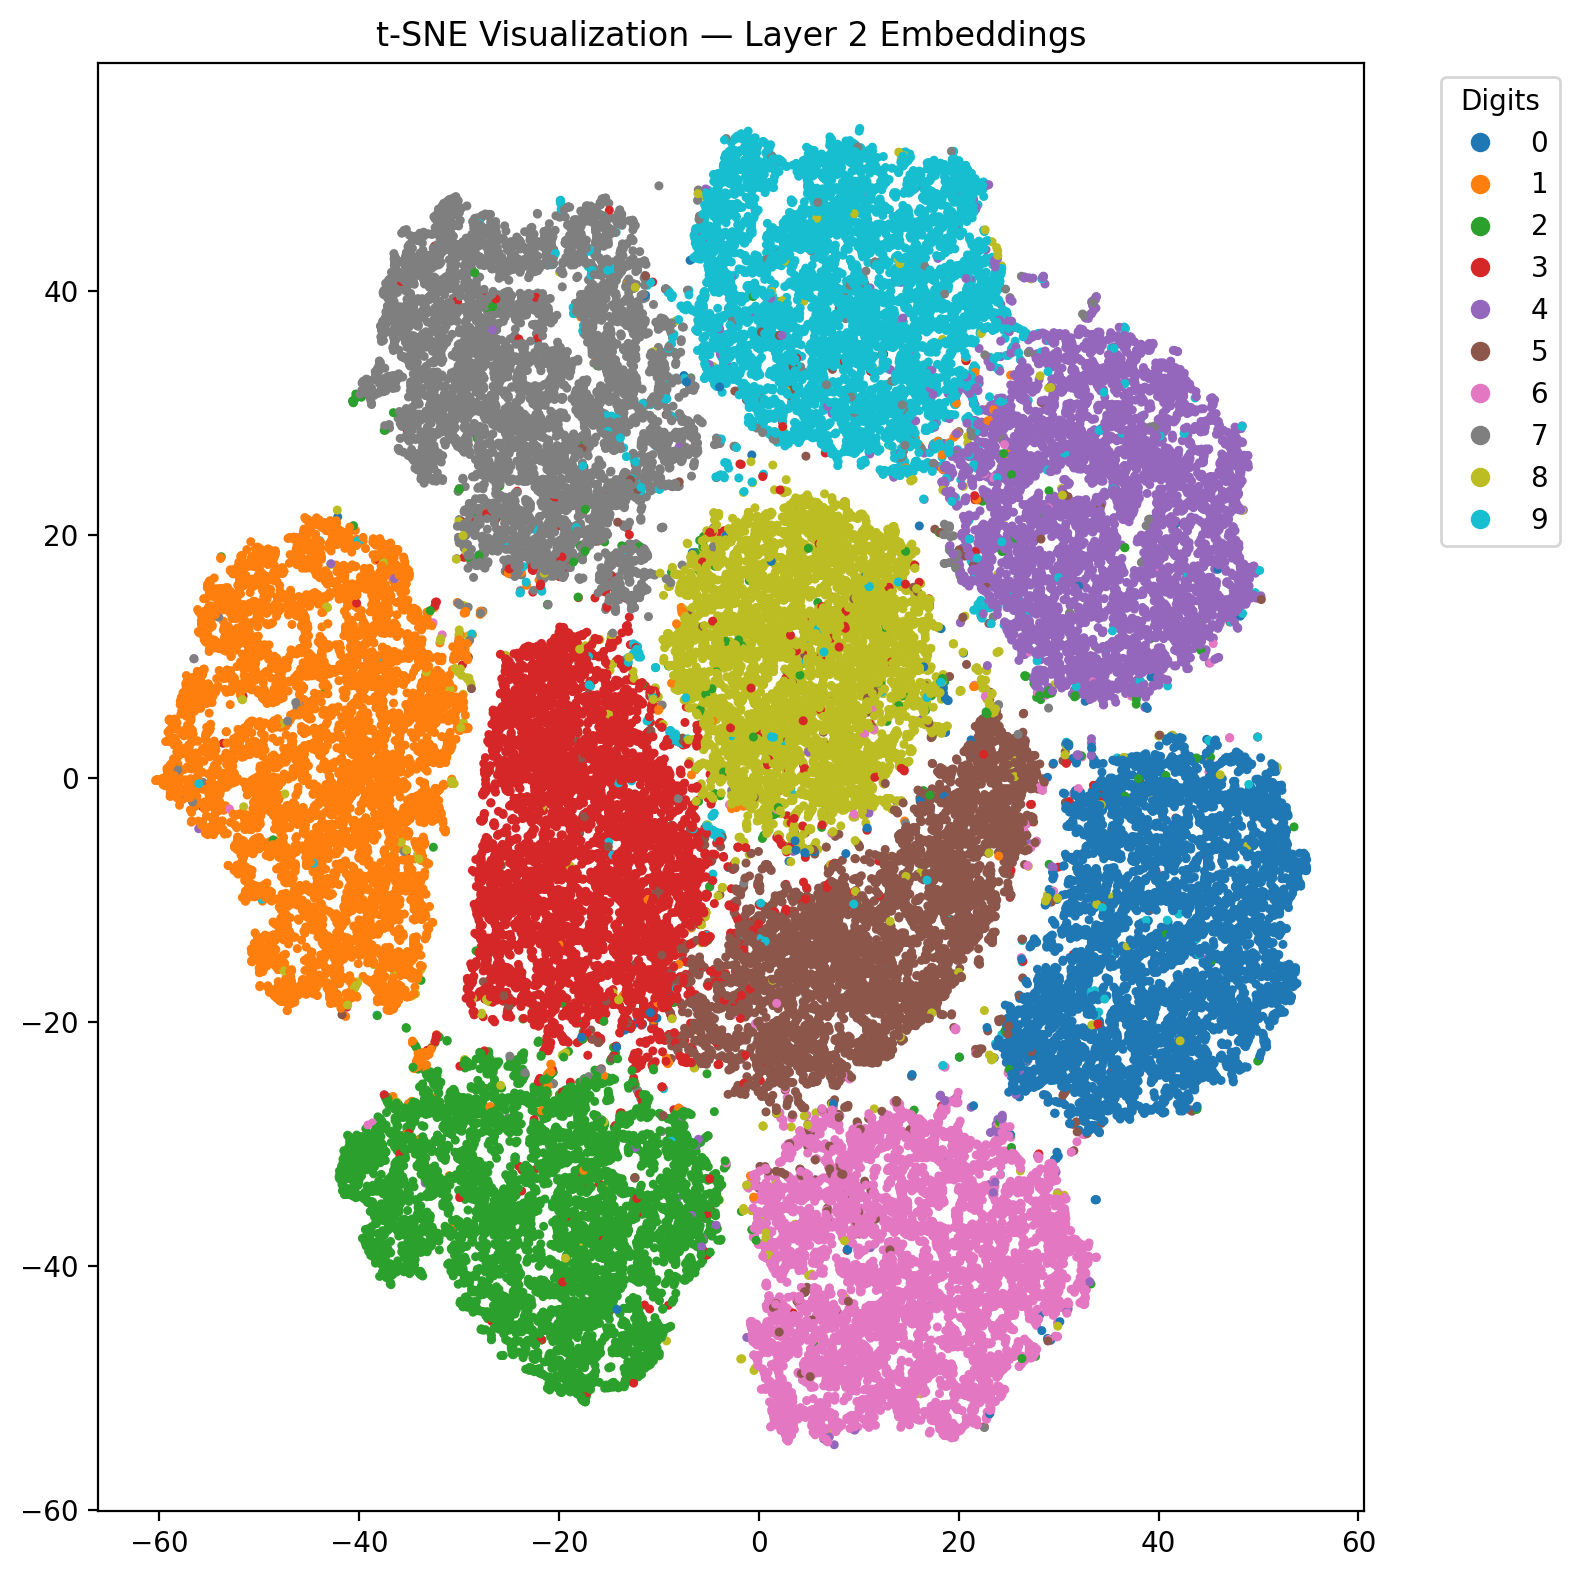

C:\Users\ginis\AppData\Local\Temp\ipykernel_18660\3192885909.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)


Running t-SNE on 60000 samples...


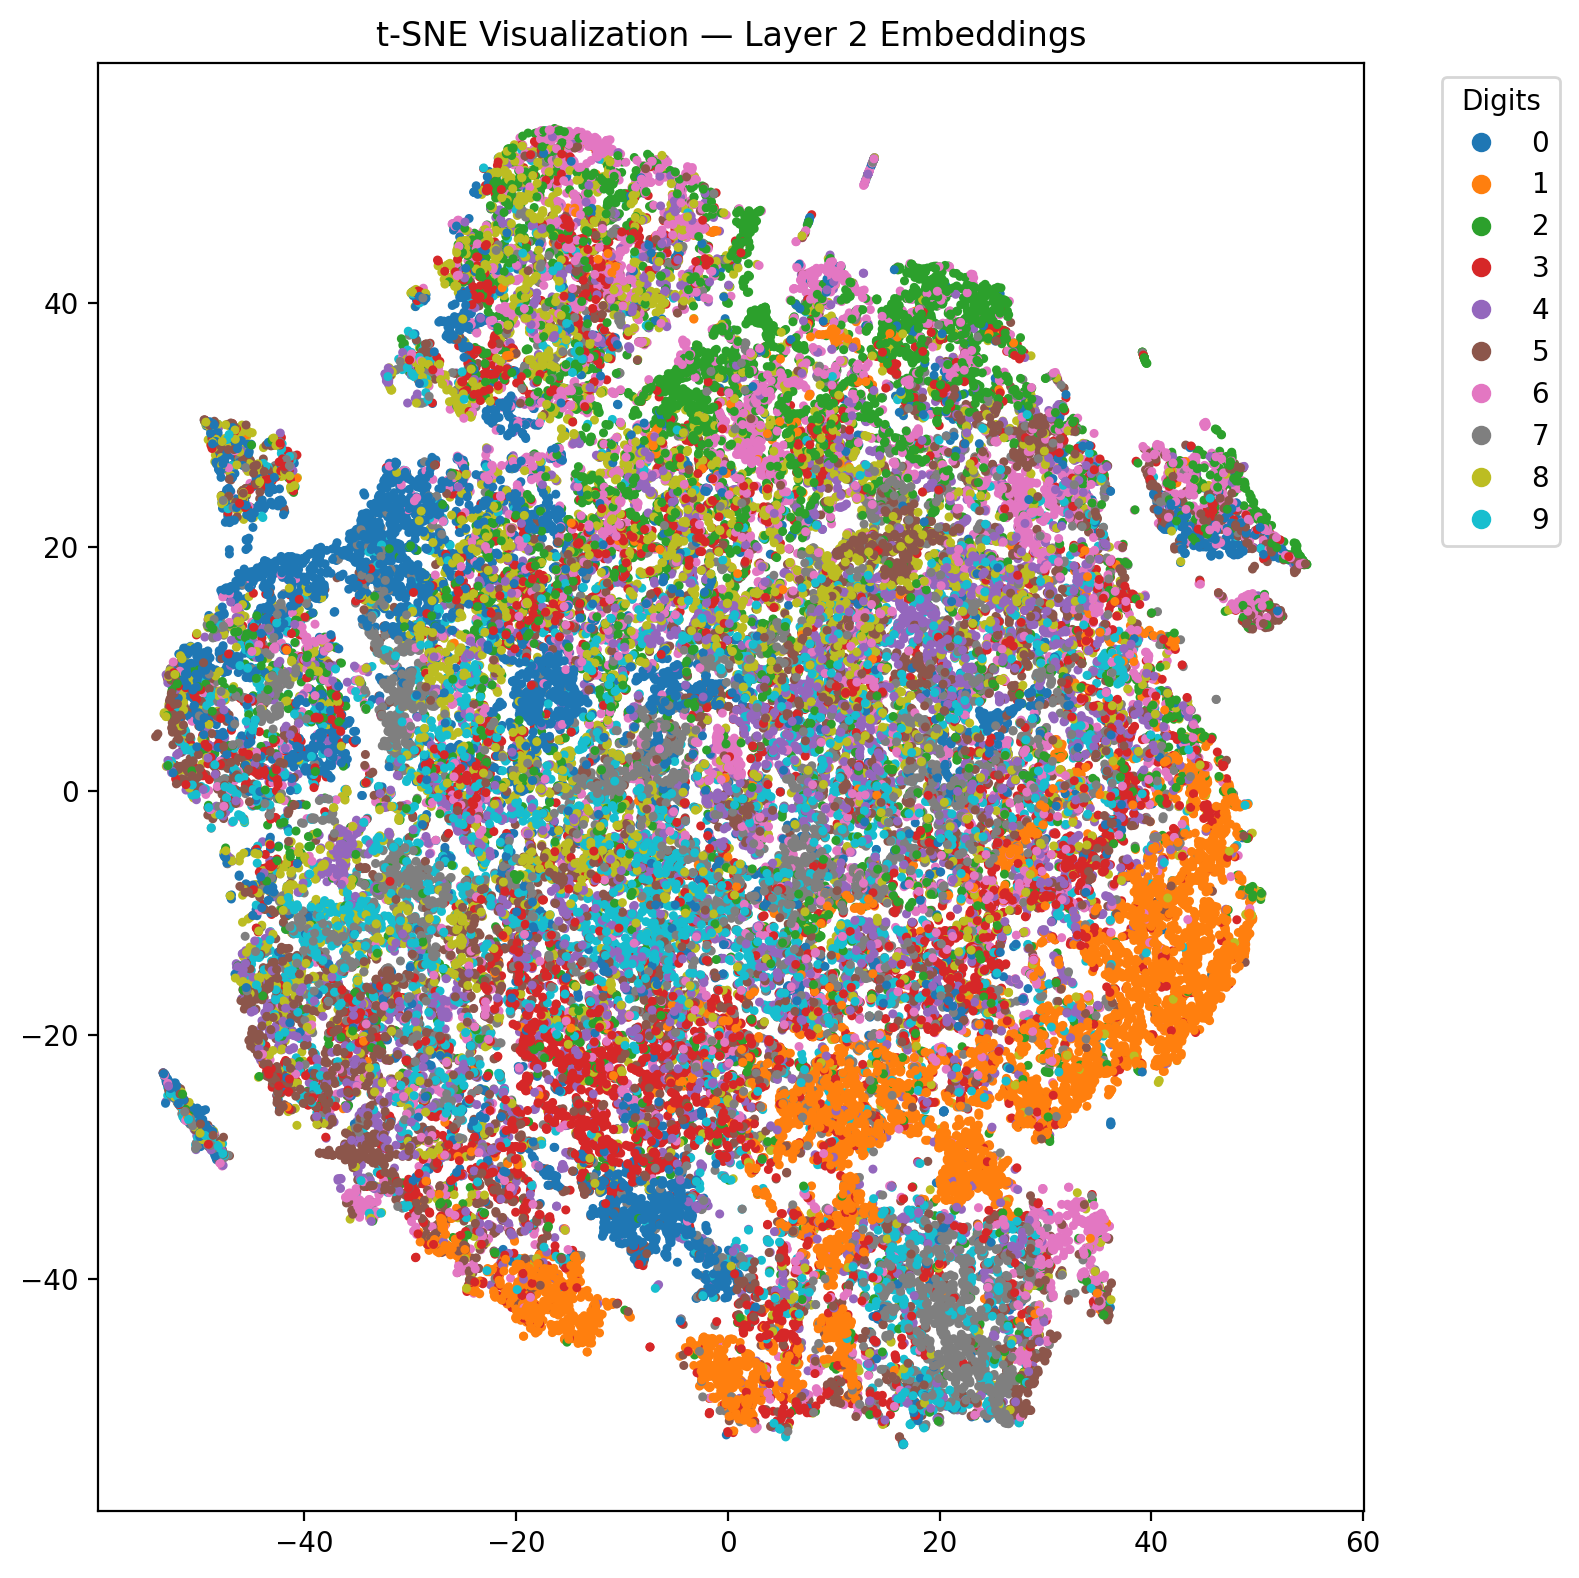

In [ ]:
untrained_model = MLP()

plot_tsne(model, X_train, y_train, device=device)

plot_tsne(untrained_model, X_train, y_train, device=device)



### **t-SNE Visualization — Comparison Between Trained and Untrained Models**

#### **Observation**

The t-SNE plots visualize the 20-neuron hidden layer embeddings for all 10 MNIST digits.  
This comparison shows how the internal feature space evolves before and after training.

- **Untrained Model:**  
  - The plot shows a random scatter with heavy overlap between all digit classes.  
  - Points of different colors (digits) are mixed together, meaning the model’s features are not meaningful yet.  
  - Since the weights are initialized randomly, there is no separation or clustering hence the network has not learned any discriminative structure.

- **Trained Model:**  
  - The t-SNE visualization forms distinct, well-separated clusters for each digit.  
  - Digits with similar shapes (e.g., **4 and 9**, **3 and 5**) appear closer but still partially distinct, showing the network has learned meaningful representations.  
  - This clear grouping indicates that the hidden layer has learned to encode class-specific features effectively.

#### **Comparison**

| Aspect | **Untrained Model** | **Trained Model** |
|:-------|:--------------------|:------------------|
| **Feature organization** | Random and scattered | Clearly clustered by digit |
| **Color mixing** | Heavy overlap | Minimal overlap |
| **Class separability** | None | Strong separation between digits |
| **Interpretation** | Weights uninitialized → no meaningful embeddings | Network has learned non-linear patterns that distinguish digits |

#### **Conclusion**

The trained MLP’s t-SNE plot demonstrates how training transforms random initial features into **structured, separable clusters** in the latent space.  
This visually confirms that the network’s hidden layer successfully captures **discriminative patterns** that help distinguish between handwritten digits.


In [196]:

(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion.reshape(-1, 28 * 28)
X_test_fashion = X_test_fashion.reshape(-1, 28 * 28)

X_train_fashion = torch.from_numpy(X_train_fashion).float().reshape(-1, 28 * 28) / 255
y_train_fashion = torch.from_numpy(y_train_fashion).long()

X_test_fashion = torch.from_numpy(X_test_fashion).float().reshape(-1, 28 * 28) / 255
y_test_fashion = torch.from_numpy(y_test_fashion).long()

print( X_train_fashion.shape, y_train_fashion.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [197]:


batch_size = 128

train_loader_fashion = DataLoader(TensorDataset(X_train_fashion, y_train_fashion), batch_size=batch_size, shuffle=True)
test_loader_fashion = DataLoader(TensorDataset(X_test_fashion, y_test_fashion), batch_size=batch_size, shuffle=False)



MLP Test Accuracy: 0.0866, F1-score: 0.0597
Confusion Matrix:


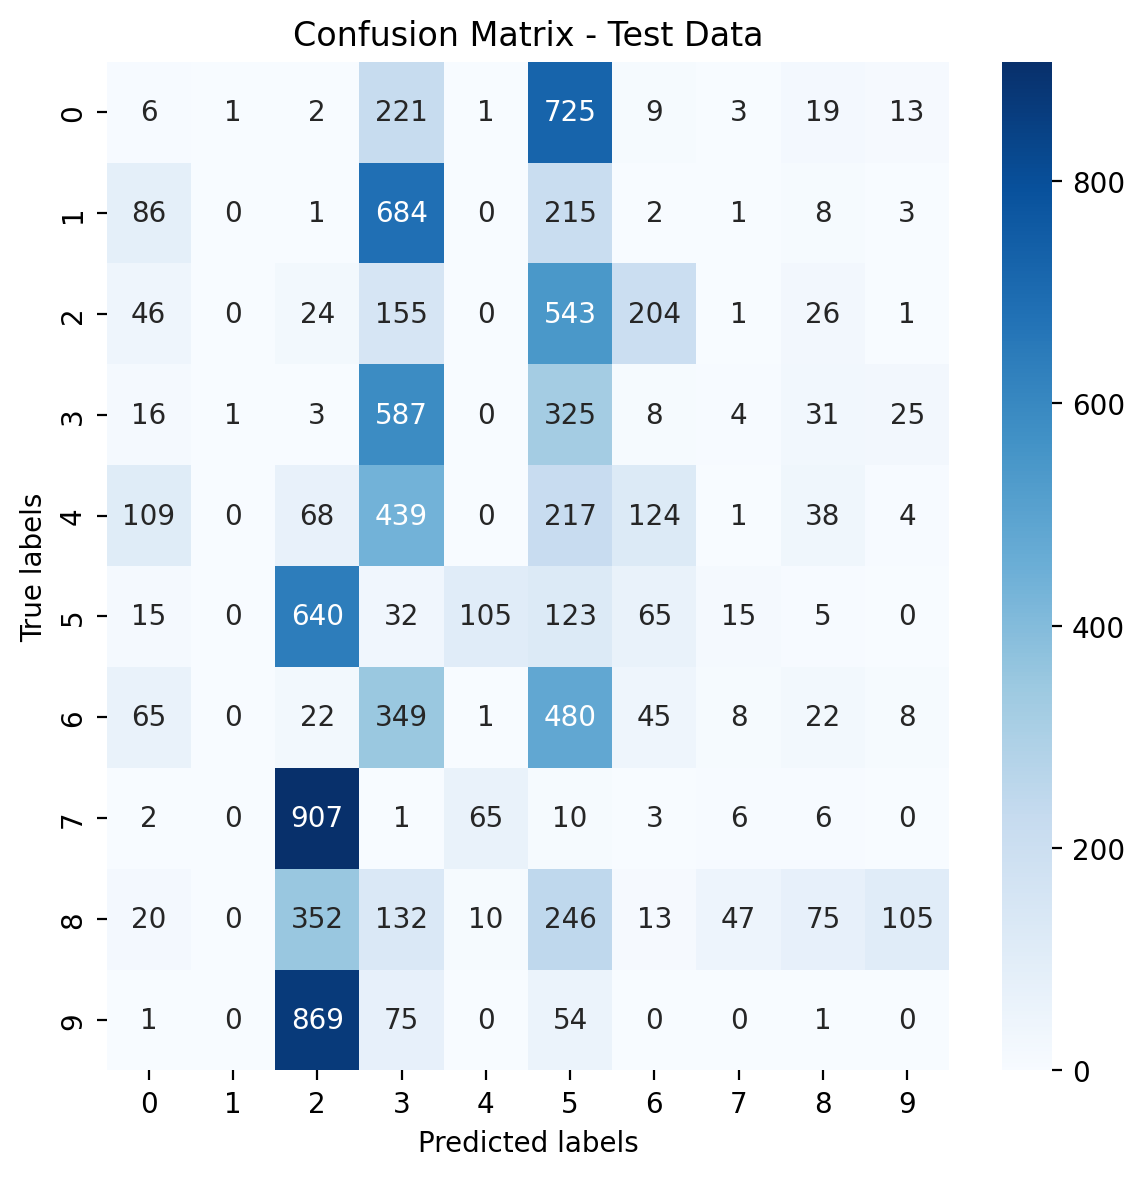

Most commonly confused with 0: [3 8]
Most commonly confused with 1: [5 0]
Most commonly confused with 2: [6 3]
Most commonly confused with 3: [5 8]
Most commonly confused with 4: [5 6]
Most commonly confused with 5: [5 4]
Most commonly confused with 6: [3 0]
Most commonly confused with 7: [4 5]
Most commonly confused with 8: [5 3]
Most commonly confused with 9: [3 5]


In [198]:
 
model.eval()
y_true_fashion, y_pred_fashion = [], []

with torch.no_grad():
    for images, labels in test_loader_fashion:
        images = images.to(device)
        outputs_fashion = model(images)
        preds_fashion = torch.argmax(outputs_fashion, dim=1).cpu().numpy()
        y_pred_fashion.extend(preds_fashion)
        y_true_fashion.extend(labels.numpy())

acc_fashion = accuracy_score(y_true_fashion, y_pred_fashion)
f1_fashion = f1_score(y_true_fashion, y_pred_fashion, average='macro')
print(f"MLP Test Accuracy: {acc_fashion:.4f}, F1-score: {f1_fashion:.4f}")
print("Confusion Matrix:")
cm_fashion = confusion_matrix(y_true_fashion, y_pred_fashion)


# Plot confusion matrices
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Blues', ax=axs)
axs.set_title('Confusion Matrix - Test Data')
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels')


plt.tight_layout()
plt.show()

for i in range(10):
	print(f"Most commonly confused with {i}:", cm_fashion[i].argsort()[-3:-1][::-1])



Cross-domain (FashionMNIST) Accuracy: 0.0866, F1-score: 0.0597
Confusion Matrix:


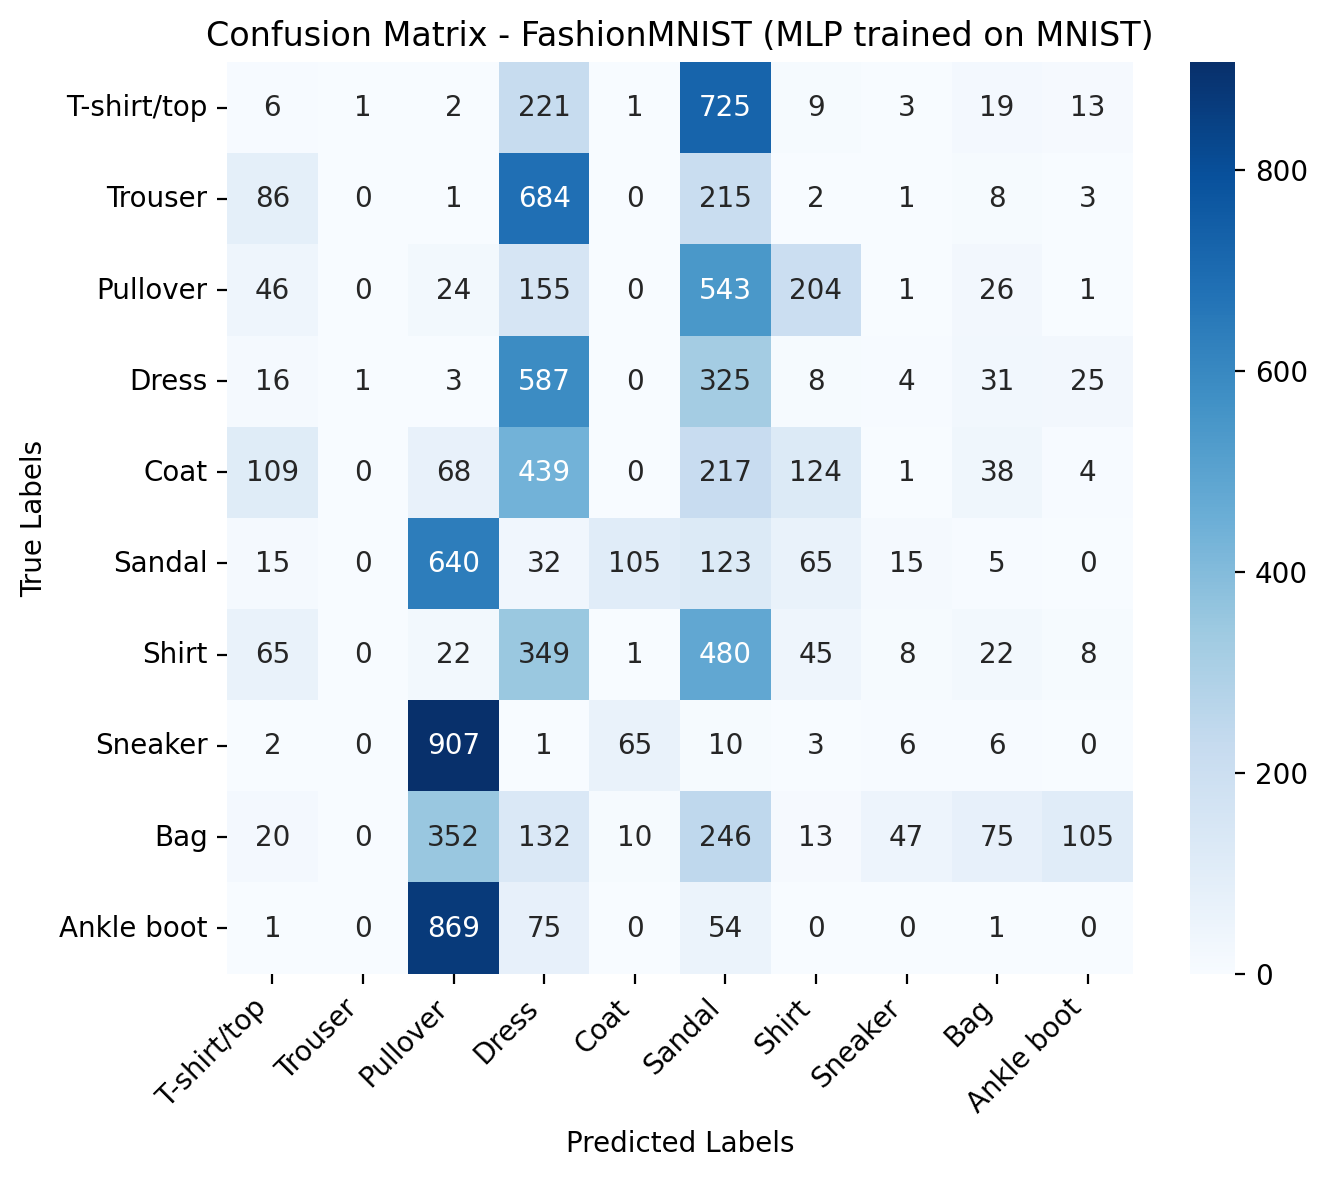

T-shirt/top is most confused with: Dress and Bag
Trouser is most confused with: Sandal and T-shirt/top
Pullover is most confused with: Shirt and Dress
Dress is most confused with: Sandal and Bag
Coat is most confused with: Sandal and Shirt
Sandal is most confused with: Sandal and Coat
Shirt is most confused with: Dress and T-shirt/top
Sneaker is most confused with: Coat and Sandal
Bag is most confused with: Sandal and Dress
Ankle boot is most confused with: Dress and Sandal


In [199]:


# FashionMNIST class labels
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

model.eval()
y_true_fashion, y_pred_fashion = [], []

with torch.no_grad():
    for images, labels in test_loader_fashion:
        images = images.view(images.size(0), -1).to(device)  # flatten for MLP
        outputs_fashion = model(images)
        preds_fashion = torch.argmax(outputs_fashion, dim=1).cpu().numpy()
        y_pred_fashion.extend(preds_fashion)
        y_true_fashion.extend(labels.numpy())

# Compute metrics
acc_fashion = accuracy_score(y_true_fashion, y_pred_fashion)
f1_fashion = f1_score(y_true_fashion, y_pred_fashion, average='macro')

print(f"Cross-domain (FashionMNIST) Accuracy: {acc_fashion:.4f}, F1-score: {f1_fashion:.4f}")
print("Confusion Matrix:")

cm_fashion = confusion_matrix(y_true_fashion, y_pred_fashion)

# --- Plot confusion matrix with readable labels ---
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Blues',
            xticklabels=fashion_labels, yticklabels=fashion_labels, ax=ax)
ax.set_title('Confusion Matrix - FashionMNIST (MLP trained on MNIST)')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Print most confused classes in readable form ---
for i in range(10):
    if cm_fashion[i].sum() > 0:
        top_confused = cm_fashion[i].argsort()[-3:-1][::-1]
        print(f"{fashion_labels[i]} is most confused with: {fashion_labels[top_confused[0]]} and {fashion_labels[top_confused[1]]}")


In [200]:

print('Test Data Classification Report:')
print(classification_report(y_test_fashion, y_pred_fashion, target_names=fashion_labels))

Test Data Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.02      0.01      0.01      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.01      0.02      0.01      1000
       Dress       0.22      0.59      0.32      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.04      0.12      0.06      1000
       Shirt       0.10      0.04      0.06      1000
     Sneaker       0.07      0.01      0.01      1000
         Bag       0.32      0.07      0.12      1000
  Ankle boot       0.00      0.00      0.00      1000

    accuracy                           0.09     10000
   macro avg       0.08      0.09      0.06     10000
weighted avg       0.08      0.09      0.06     10000



TSNE For MNIST:
Running t-SNE on 60000 samples...


C:\Users\ginis\AppData\Local\Temp\ipykernel_18660\3192885909.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)


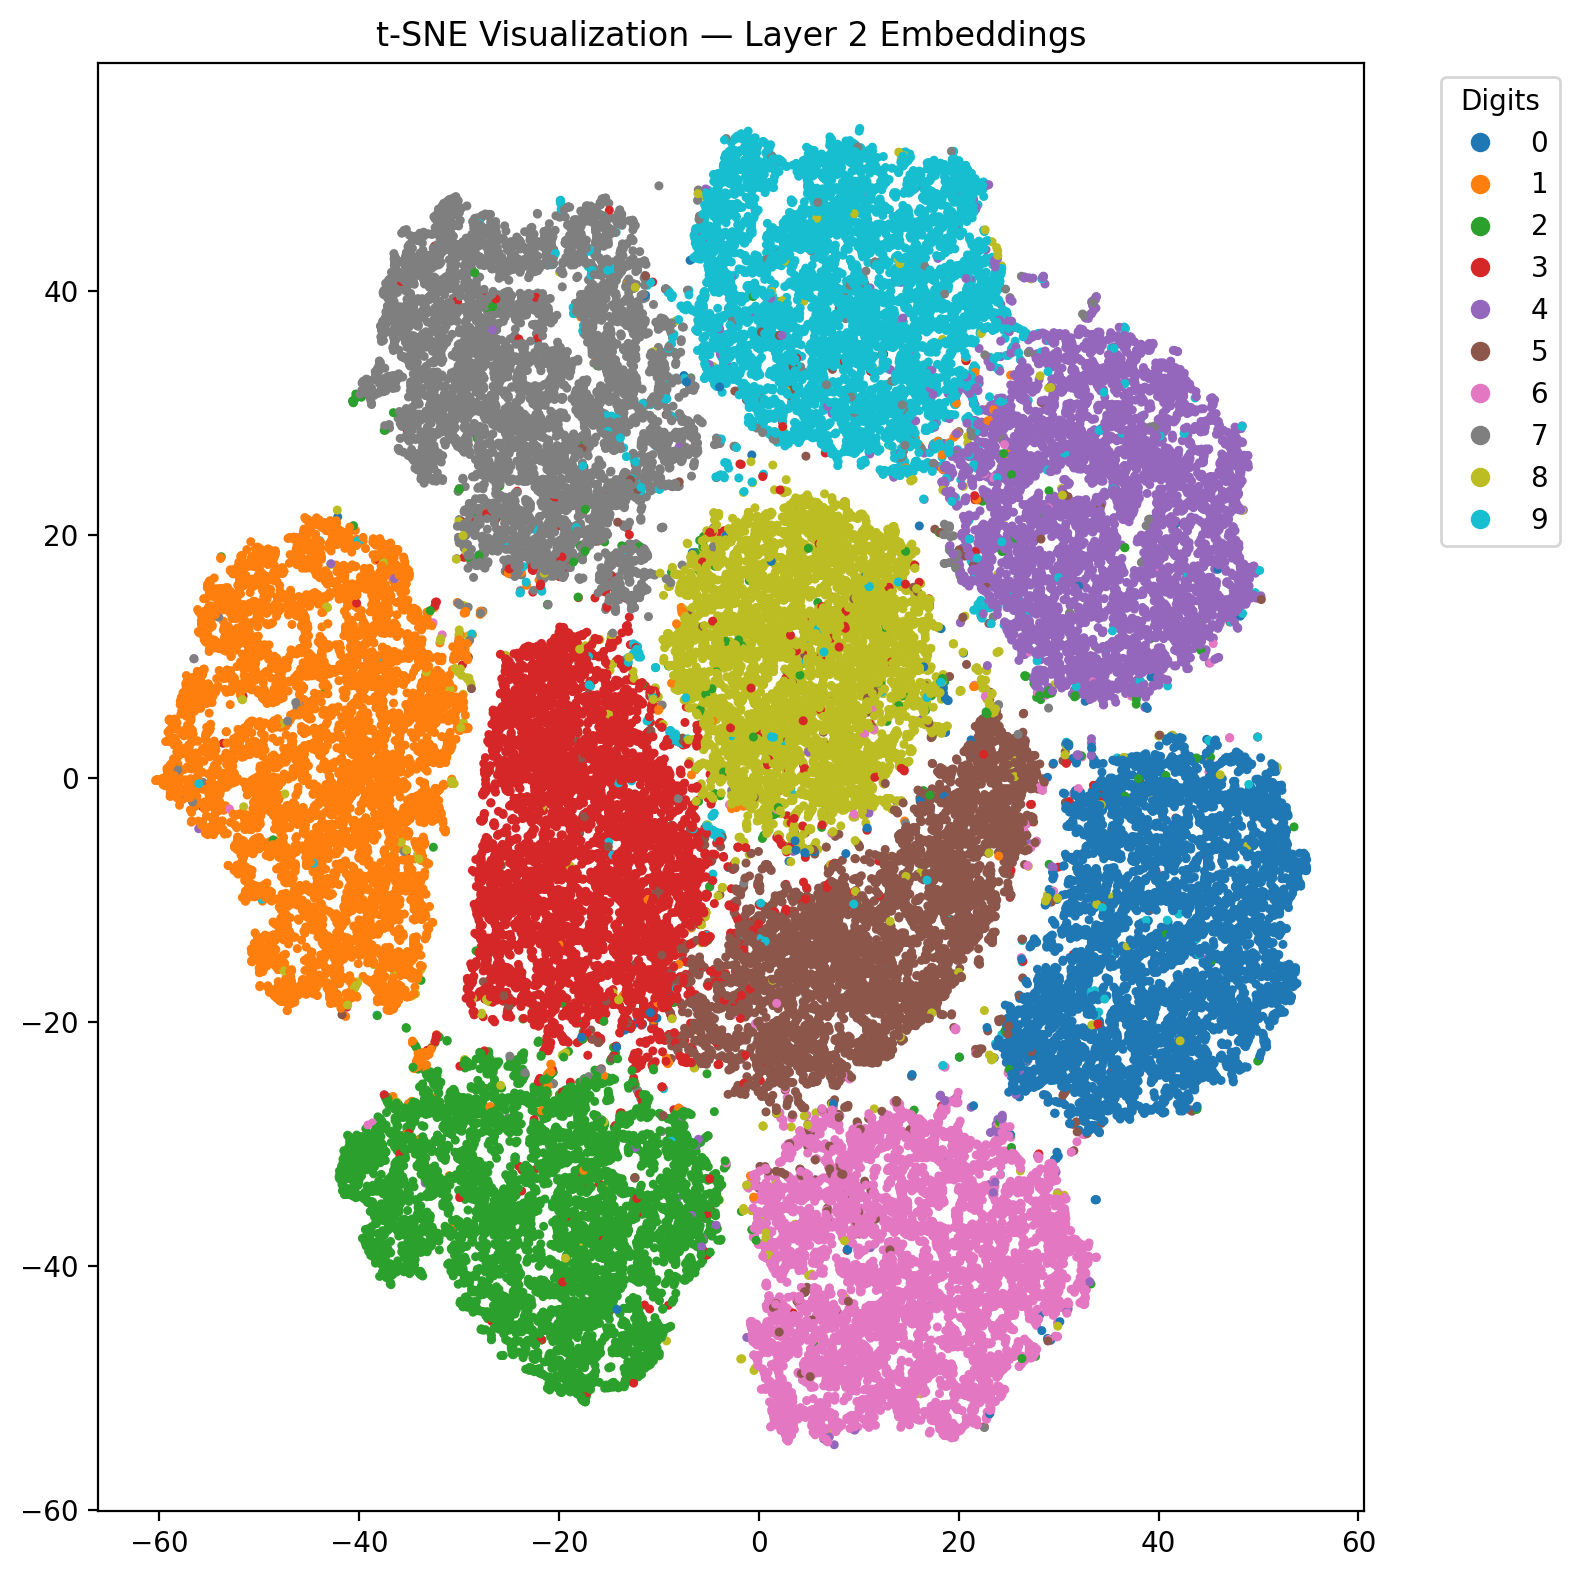

----------------------------------------------------------------------------------------------------
TSNE For Fashion MNIST:
Running t-SNE on 60000 samples...


C:\Users\ginis\AppData\Local\Temp\ipykernel_18660\3192885909.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)


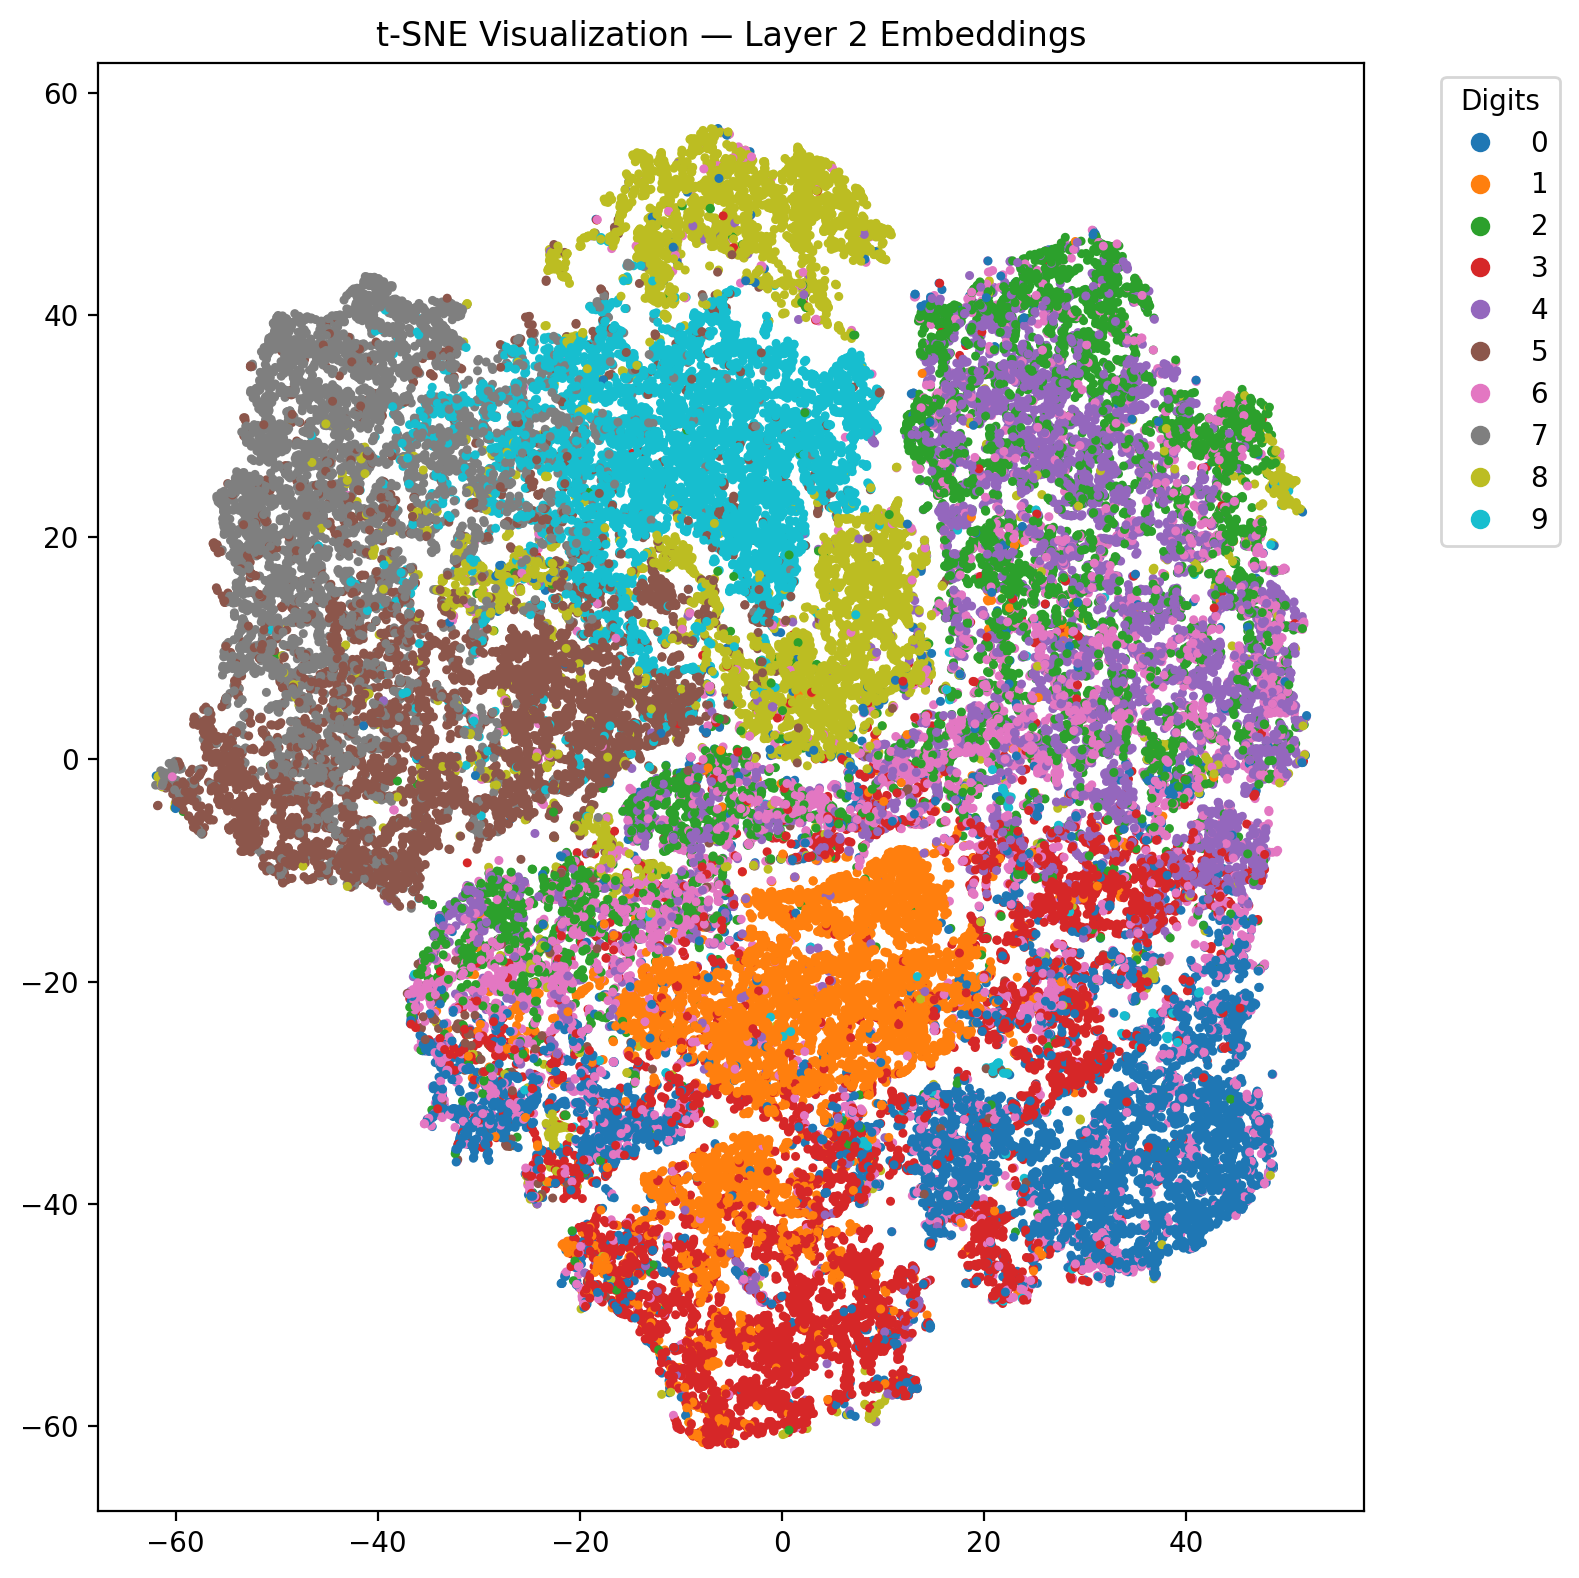

In [201]:
print('TSNE For MNIST:')
plot_tsne(model, X_train, y_train, device=device)

print("-"*100)
print('TSNE For Fashion MNIST:')
plot_tsne(model, X_train_fashion, y_train_fashion, device=device)


### Cross-Domain Testing —> MNIST Model on Fashion-MNIST

#### Observation

The trained MLP, originally trained on the MNIST digit dataset, was tested on the Fashion-MNIST dataset.  
Since MNIST contains handwritten digits and Fashion-MNIST contains clothing items, there is no direct visual or feature similarity between the two domains.

- The confusion matrix shows extremely low accuracy (≈8.6%) and poor F1-score (0.0597).  
  - Most predictions are incorrect, and many classes are confused with multiple others (for example, T-shirt/top misclassified as Dress or Bag).  
  - This indicates that the model’s learned features do not generalize well to unseen data from a different domain.  

- The t-SNE visualization for Fashion-MNIST embeddings reveals a loss of clear clustering:  
  - Unlike MNIST (where clusters are distinct and well-separated), Fashion-MNIST embeddings appear highly mixed and overlapping.  
  - This suggests that the feature space learned by the model for digits fails to meaningfully represent clothing items.  

#### Comparison Between MNIST and Fashion-MNIST t-SNE Plots

| Aspect | MNIST Embeddings | Fashion-MNIST Embeddings |
|:-------|:-----------------|:-------------------------|
| Cluster structure | Clear, separate clusters for each digit | Overlapping, mixed points with no clear boundaries |
| Feature representation | Strong class-specific patterns | Weak and non-discriminative features |
| Interpretation | Network learned meaningful digit representations | Model fails to adapt to new visual domain |
| Generalization | High within-domain accuracy | Poor cross-domain performance |

#### Conclusion

The experiment highlights that an MLP trained on MNIST does not generalize to Fashion-MNIST, even though both datasets share similar input dimensions and grayscale images.  
The t-SNE and confusion matrix together confirm that the learned latent features are domain-specific, meaning the network captures digit-related patterns that do not transfer to clothing-related features.
